# Pytorch Examples & Practice

## Learning Goals

Today's goals are to

1. Practice writing model and training code using PyTorch
2. Practice translating between mathematical, visual, and code representations of a model
3. Understand the way in which deep neural networks can be thought of as representation learners 
4. Understand the purpose of common neural network training techniques, like dropout, normalization, etc.

## Today's Activity

Today's activity is split into a couple of parts, all designed to further familiarize yourself with PyTorch and the structure of deep neural networks. The assignment has 4 parts:

First, a demo of the XOR problem to illustrate how we can build representation spaces that allow for us to solve non-linear problems with FFNs that something like a perceptron cannot solve!

Second, a demo of utilizing GPUs to train models in pytorch. I recommend running this using Google Colab, linked below.

Third, a few odds and ends needed to discuss interesting ML architectures for NLP. 

Fourth, a few practice problems to make sure you understand how models can be communicated, and how to translate them into working code.

This is meant as a combo of an interactive reading/demo and a few problems. There is not any substantial new material since we don't have lecture, so I will not grade any submission for this assignment. However, you should feel free to check answers to the practice problems with me during office hours!

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

### The XOR Problem

Here, we'll demo the classic XOR problem by building a (kinda) perceptron and a logistic regression model (i.e., a model with a *non-linearity*) and see how well they learn the task. Here, first, let's specify how the two models should look mathematically:

The perceptron should have it's output be $$\hat{y} = w \cdot x + b$$ and assign label $\text{sign}(\hat{y})$ where $$ \text{sign}(x) = \begin{cases} 1, x \geq 0 \\ -1, \text{otherwise}  \end{cases} $$ for parameters $w \in \mathbb{R}^n$ (an n-dimensional vector!) and $b \in \mathbb{R}$ (a *scalar*, or just a real number). You can do this by making tensors and wrapping them with `nn.Parameter`, but is there a simpler way?

Our loss function is going to be what we call *perceptron loss*: $$loss(y, \hat{y}) = \max(0, -\hat{y} \cdot y)$$. For labels 1 and -1, what values will the loss function take? When will loss be 0 and when will it be positive? When it's positive, how large is it?

In [ ]:
class Perceptron(nn.Module):
    def __init__(self, n : int):
        super(Perceptron, self).__init__()

        self.linear = nn.Linear(n, 1)

    def forward(self, x : torch.Tensor):
        return self.linear(x)

def loss_f(y : float, y_hat : float):
    return torch.max(torch.tensor(0), -y * y_hat)

def sign(x):
    if x < 0:
        return -1.0
    return 1.0

And, of course, the XOR problem: For inputs $a, b \in \{0, 1\}$, $$ xor(a, b) = \begin{cases}0, a = b \\ 1, \text{otherwise}, \end{cases} $$ represented as a dataset as below. Note that since our perceptron assigns classes values 1 and -1, the *class* 0 takes value -1: A strange quirk of binary classification with perceptrons!

We'll also consider, to set a baseline, the comparable OR problem: For inputs $a, b \in \{0, 1\}$, $$ or(a, b) = \begin{cases}0, a = b = 0 \\ 1, \text{otherwise}, \end{cases} $$That is, $or(a,b)$ is true if either $a$ is 1, $b$ is 1, or $a$ and $b$ are 1. This function *is* linearly separable, so we should expect our perceptrons to be able to learn this function.

In [ ]:
xor_data = [([0.0, 0.0], -1.0), 
            ([0.0, 1.0], 1.0),
            ([1.0, 0.0], 1.0),
            ([1.0, 1.0], -1.0)]

or_data = [([0.0, 0.0], -1.0), 
           ([0.0, 1.0], 1.0),
           ([1.0, 0.0], 1.0),
           ([1.0, 1.0], 1.0)]

Now, here is code to train a model. Note how *general* the code is: We'll use it to train the feedforward network we'll compare the perceptron to!

Again, note the 4 steps we conduct in a loop: We use our (probably bad) model to predict an output, we compute a loss (i.e., measure *how* bad our model is), we compute the gradient with respect to each parameter (i.e., how should I change each parameter so my model's loss would go down), and then we update those parameters by a little bit (proportional to our *learning rate*). By repeating this over and over again, our model will (hopefully) get better!

In [ ]:
import random

def train_model(model, lr, num_epochs, data):
    optimizer = torch.optim.SGD(model.parameters(), lr = lr)
    losses = []
    
    for epoch in range(num_epochs):
        # process the examples in a random order each epoch
        random.shuffle(data)
        
        total_loss = 0.0
        
        for x, y in data:
            # predict
            x = torch.tensor(x)
            y = torch.tensor(y)
            y_hat = model(x)
    
            # compute loss
            loss = loss_f(y, y_hat)
    
            # compute gradient
            loss.backward()
            total_loss += loss.item()
        
            # update weights
            optimizer.step()
            optimizer.zero_grad()
            
        losses.append(total_loss)
        
    return model, losses

Let's train our perceptron on the OR problem!

In [ ]:
or_perceptron = Perceptron(2)
or_perceptron, or_losses = train_model(or_perceptron, 0.01, 5000, or_data)

Now let's inspect our *training curve*, a plot that shows how the training loss of our model changes over time (here, each epoch). We should see that the model learns fairly quickly!

In [ ]:
import matplotlib.pyplot as plt
plt.plot(or_losses)

This is a very simple model, so it can be instructive to look directly at the values the models' parameters!

In [ ]:
for name, param in or_perceptron.named_parameters():
    print(name)
    print(param)

Since we randomly initialize, I can't say exactly what these values should be (or if the model even converged!), but at the very least, we can visualize how the model you trained classifies. 

We can do this by looking at the *hyperplane* (i.e., line, but sometimes in higher dimensions) that separates positive and negative examples for our perceptron. I've promised you that classification with a perceptron is equivalent to drawing a line to separate the points, and here is where I show you how:

Our perceptron assigns each point $(x,y)$ in 2-D space a score $w_1x + w_2y + b$. This should look familiar: We just represent our weight vector as it's 2 values $w_1, w_2$ and the input vector as it's 2 values $x, y$. Some of those points are going to be positive, others will be negative, but critically, since the function is linear with respect to x and y, there is a single line that will cross our plot that separates these positive and negative examples. These are exactly the points at which we assign a score of 0! This is our *decision boundary*. To draw this line, we can turn this into an equation of a line that looks more familiar:

$$ w_1x + w_2y + b = 0 $$
$$ w_2y = -b - w_1x $$
$$ y = -\frac{w_1x + b}{w_2} $$
$$ y = -\frac{w_1}{w_2}x + \frac{b}{w_2} $$

Given a trained model's parameters, we can actually compute some points

In [ ]:
def get_y(x, w, b):
    return (-(b + (w[0] * x))/w[1]).item()

And plot the decision boundary directly! Here I also add red dots to indicate +1 labeled inputs and blue dots to indicate -1 labeled inputs (i.e., 0 values for the OR problem).

In [ ]:
plt.plot([-0.5, 1.5], [get_y(-0.5, or_perceptron.linear.weight.view(-1), or_perceptron.linear.bias), 
                  get_y(1.5, or_perceptron.linear.weight.view(-1), or_perceptron.linear.bias)])
plt.plot([0], [0], "bo")
plt.plot([0,1,1], [1,0,1], "ro")

And hopefully you should see that we have, in fact, classified inputs appropriately! The line separates the blue and red points!

Now we can also just have our model classify inputs, and verify the same thing: I print the input, the provided label, and the target label.

In [ ]:
for x, y in or_data:
    x = torch.tensor(x)
    print(x, sign(or_perceptron(x)), y)

#### Now more exclusive!

Let's go through the same thing with the XOR problem:

In [ ]:
xor_perceptron = Perceptron(2)
xor_perceptron, xor_losses = train_model(xor_perceptron, 0.01, 5000, xor_data)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(xor_losses)

In [ ]:
plt.plot([-0.5, 1.5], 
         [get_y(-0.5, xor_perceptron.linear.weight.view(-1), xor_perceptron.linear.bias), 
          get_y(1.5, xor_perceptron.linear.weight.view(-1), xor_perceptron.linear.bias)])
plt.plot([0,1], [0,1], "bo")
plt.plot([0,1], [1,0], "ro")

And here's the rub: no matter how hard we try, the model will never learn the right function --- we'll always misclassify something!

In [ ]:
for x, y in or_data:
    x = torch.tensor(x)
    print(x, sign(xor_perceptron(x)), y)

#### Now with an FFN!

Now let's build a 2-layer "deep" neural network to solve this problem.

Mostly following Goodfellow (2016), we'll model our network as follows:

We have an input $x \in \mathbb{R}^2$ which we feed into a single linear layer

$$ h = \sigma(W_1x + b_1) $$ with weights $W_1 \in \text{Mat}(2,2)$ (a 2x2 matrix) and $b \in \mathbb{R}^2$.

and then feed that into an output layer

$$ o = W_2h + b_2 $$ with weights $W_2 \in \text{Mat}(2,1)$ (essentially in $\mathbb{R}^2$) and $b \in \mathbb{R}$. 

We can then just check the sign as per the perceptron!

Note the key difference is that we add a *single hidden layer* --- everything else is just a perceptron!

In [ ]:
class FFN(nn.Module):
    def __init__(self, n : int):
        super(FFN, self).__init__()

        self.linear = nn.Linear(n, n)
        self.output = nn.Linear(n, 1)

    def forward(self, x : torch.Tensor):
        h = F.sigmoid(self.linear(x))
        o = self.output(h)
        return o

In [ ]:
xor_ffn = FFN(2)
xor_ffn, ffn_losses = train_model(xor_ffn, 1, 5000, xor_data)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(ffn_losses)

In [ ]:
for x, y in xor_data:
    x = torch.tensor(x)
    print(x, sign(xor_ffn(x)), y)

Note that training here is a bit finicky: A lot of this depends on the initial conditions of our network so we don't end up an a local minimum that doesn't solve the problem. Don't be too shocked if some random start doesn't lead to an optimal solution, but some do! I promise!

Now let's look at *why* our single new layer lets us perform miracles. We are applying a non-linear transformation to get from our input $x$ to a representation in a hidden space $h$. If this results in a set of linearly separable points, then our perceptron will be able to learn a solution to the XOR problem! Let's visualize this:

First, we'll compute the representations of our input in the hidden space, annotated with their coordinates in the input space.

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))

for x, y in xor_data:
    h = F.sigmoid(xor_ffn.linear(torch.tensor(x)))
    ax[0].plot(*x, 
            "ro" if y == 1 else "bo")
    ax[1].plot(*h.detach(), 
            "ro" if y == 1 else "bo")
    ax[1].annotate("({}, {})".format(*x), xy=h.detach(),
                xytext=(2, 2), textcoords='offset points')

ax[1].axline([0, get_y(0, xor_ffn.output.weight.view(-1), xor_ffn.output.bias)], 
             [0.1, get_y(0.1, xor_ffn.output.weight.view(-1), xor_ffn.output.bias)])

Note that (if your model trained correctly) this should be linearly separable! The first plot shows the inputs in their own 2D space, and the second shows the input points transformed into points in the hidden space, as well as the decision boundary the model has learned. 

You can think about the model as two pieces: An *encoder* that builds a representatation (vector of features) of the input (here, the `linear` layer) and then a *decoder, or *classifier*, portion of the model that turns that represention into a label. The encoder part of the model essentially automates feature engineering for us --- gradient descent (hopefully) finds features that help classification!

## Pytorch on a GPU

So far, we've been running code on CPUs, which, as we've discussed, is not optimal when we're essentially just doing matrix operations. Instead, we should be leveraging GPUs when available. Of course, "when available" varies, especially on your personal machines. I personally recommend using [Google CoLab](https://colab.research.google.com/) to benchmark the code below. Uploading this notebook should work! Make sure to enable the GPU in by navigating to the menu in Edit -> Notebook Setting.

To manage GPU usage, PyTorch uses the concept of a `device` representing either the CPU or GPU. When you perform a computation, all tensors used in the computation must be on the same device and computations will be performed on that device.

For us, if we want to use an GPU, we'll need to 

1. Figure out what devices are available to us.
2. Move relevant objects to the intended device.
3. Do the computations we want, and move them back to the CPU if necessary.

We can figure out what devices are available through one of several "standard" interfaces between your PyTorch code and the GPU. The primary one is [CUDA](https://pytorch.org/docs/stable/cuda.html), but others exist, like [MPS](https://pytorch.org/docs/stable/mps.html) for Apple GPUs. Here is a bit of code to check whether devices are available:

In [ ]:
print("Is a CUDA device available? {}".format(torch.cuda.is_available()))
print("Is a MPS device available? {}".format(torch.backends.mps.is_available()))

And so getting the relevant device would look something like

In [ ]:
device = torch.device("cpu") # default to the CPU

# Use something better if available
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")

Now you can manage where tensors are located by using the `.to` method of PyTorch classes. For example, for a full model, you can do:

In [ ]:
model = FFN(2)
for param in model.parameters():
    print(param)

In [ ]:
model = model.to(device)
for param in model.parameters():
    print(param)

Note (if you have a non-cpu device available) that you should now see a `device=cuda:0` or `device=mps:0` or similar message for each parameter in the model that's been moved! 

The same can be done for individual tensors too:

In [ ]:
x = torch.tensor([0.0, 1.0])
print(x)

In [ ]:
x = x.to(device)
print(x)

And you can do computations on the new device!

In [ ]:
model(x)

Now, reflecting on what we've talked about, **why does this next example throw a RuntimeError? What's wrong here?**

In [ ]:
model = FFN(2)
model = model.to(device)

model(torch.tensor([0.0, 1.0]))

Now let's compare training using GPU vs. not...

In [ ]:
import time
def train_model_timed(model, lr, num_epochs, data, device):
    model = model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr = lr)
    losses = []
    start = time.time()
    for epoch in range(num_epochs):
        # process the examples in a random order each epoch
        random.shuffle(data)
        
        total_loss = 0.0
        for x, y in data:
            # predict
            x = torch.tensor(x).to(device)
            y = torch.tensor(y).to(device)
            y_hat = model(x)
    
            # compute loss
            loss = loss_f(y, y_hat)
    
            # compute gradient
            loss.backward()
            total_loss += loss.item()
        
            # update weights
            optimizer.step()
            optimizer.zero_grad()
            
        losses.append(total_loss)
    end = time.time()
    print("{} epochs in {:.3}s".format(num_epochs, end - start))
        
    return model, losses

In [ ]:
model_1 = train_model_timed(model, 0.01, 1000, xor_data, "cpu")

In [ ]:
model_1 = train_model_timed(model, 0.01, 1000, xor_data, device)

Wait... our GPU makes us slower? 

Consider for a moment the size of our model. There aren't a whole lot of matrix operations to parallelize if we're multiplying 2x2 matrices! In fact, we're slowing ourselves down by wasting a ton of time moving our inputs and outputs onto the GPU! To actually get gains, we need a larger model. Let's consider the Neural Trigram Model from the last activity... Collapse this next section to skip some old code!

#### Neural Trigram Code

In [ ]:
from typing import Sequence

class NeuralTrigram(nn.Module):
    def __init__(self, vocab_size, embeddings_size, hidden_size):
        super(NeuralTrigram, self).__init__()
        
        self.embed = nn.Embedding(vocab_size, embeddings_size)
        self.linear = nn.Linear(2*embeddings_size, hidden_size)
        self.output = nn.Linear(hidden_size, vocab_size)
        self.softmax = nn.LogSoftmax(dim=-1)

    def forward(self, C : torch.Tensor):
        *batch_dims, _ = C.size()
        embeds = self.embed(C)
        context = embeds.view(*batch_dims, -1)
        h = F.tanh(self.linear(context))
        logits = self.output(h)
        return self.softmax(logits)

In [ ]:
def get_batched_ngrams(data, n, batch_size):
    # Drop words so data is evenly divisible by batch size
    data = data[:(len(data)//batch_size)*batch_size]
    
    # reshape so we have batch_size x seq_len dimensions
    data = data.view(batch_size, -1)
    
    for i in range(data.size()[1] - n + 1):
        yield data[:, i:i+n-1], data[:, i+n-1]

def pad(tokens, n, eos="<eos>"):
     if n <= 1: return tokens
     out_tokens = []
     for w in tokens:
         if w == eos:
             out_tokens += [eos] * (n-1)
             continue
         out_tokens.append(w)
     out_tokens = ([eos] * (n-1)) + out_tokens
     return out_tokens

In [ ]:
with open("austen-emma.txt") as train_f:
    data = train_f.read().lower().split()

train = data[:100000]

In [ ]:
from collections import Counter

unk_thresh = 5

freqs = Counter(train)
vocab = [w for w, c in freqs.items() if c > unk_thresh] + ["<unk>"]

w2idx = {w:i for i, w in enumerate(vocab)}

train_idxs = torch.tensor([w2idx.get(w, w2idx["<unk>"]) 
                           for w in pad(train, 3)])

#### Back to new timing stuff!

And here let's time training epochs! First with CPU and then with GPU!

In [ ]:
def train_N3G_timed(model, lr, batch_size, num_epochs, train_idxs, device):
    nll = nn.NLLLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr = lr)
    model = model.to(device)
    train_idxs = train_idxs.to(device)
    
    for epoch in range(num_epochs):
        start = time.time()
        total_loss = 0
        num_batches = 0
        for C, w in get_batched_ngrams(train_idxs, 3, batch_size):
            out = model(C)
            
            loss = nll(out, w)
            loss.backward()
            
            total_loss += loss.item()
            num_batches += 1
            
            optimizer.step()
            optimizer.zero_grad()
    
        end = time.time()
        print("epoch {} in {:.3f}s".format(epoch, end - start))
    return model
        
model = NeuralTrigram(len(vocab), 1024, 1024)

In [ ]:
model = train_N3G_timed(model, 0.01, 32, 1, train_idxs, device)

In [ ]:
model = train_N3G_timed(model, 0.01, 32, 1, train_idxs, "cpu")

Again, I make no claim that your results will be consistent with mine, but they should be at least interesting! I've run this code on my Macbook with an MPS device and found the first cell (on MPS) runs in 27.693s and the second cell (on CPU) runs in 15.440s --- So much for the power of GPUs! 

However, when I ran this script on Google Colab using a T4 GPU, training ran in 3.927s (vs. 77.9s on the CoLab CPU!). Hardware dependence!

## ML Odds and Ends

This section is essentially ML potpourri --- things I'd like you to be aware of in terms of ML engineering, but don't really fit into the conceptual framework of this course. The goal here is to be able to recognize the tool, know why it's used, and then proceed with *informed ignorance* --- knowing you don't need to know about it further in the context of NLP.

The big picture is that training ML models is both an art and a science. It is often not particularly interesting (from an academic perspective) to discuss tricks to get models to train better (faster, more stable, etc.), but it is much of the real work of ML Engineering. If you have some interest in what this kind of engineering work looks like, the [Deep Learning Tuning Playbook](https://github.com/google-research/tuning_playbook) is an incredible resource for best-practices!

#### Dropout

One major pro of NNs is that the representations they learn can be *distributed* representations. That is, information necessary for classification is spread across multiple features/dimensions of a hidden representation, creating redundancy and thus robustness. However, models as we've seen them so far do not necessarily need to learn these kinds of distributed representations. In fact, it's been observed that NNs can often learn particularly brittle representations in a phenomenon known as *co-adaptation*. This, in practice, often leads to overfitting and a lack of generalization.

This is often solved by an approach called [*dropout*](http://www.cs.toronto.edu/~rsalakhu/papers/srivastava14a.pdf) --- during training, we randomly ignore (set to 0) some dimensions of our representation as part of our model, which should encourage the model to learn representations that are robust to this kind of noise! To compensate for the change in the total magnitude of the hidden state, the dropout layer scales the remaining dimensions up by a factor of $\frac{1}{1-p}$, where $p$ is the probability that any given dimension is dropped out.

We can implement dropout using the [`nn.Dropout`](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) module, like so:

In [ ]:
dropout_layer = nn.Dropout(p=0.5)

x = torch.tensor([0.0, 1.0, 2.0, 3.0, 4.0])

print(x)
print(dropout_layer(x))

And use it as a layer in a model by creating the layer in a model's `__init__` method and incorporating it into the `forward` method, as so:

In [ ]:
class FFN_Dropout(nn.Module):
    def __init__(self, n : int, dropout=0.5):
        super(FFN_Dropout, self).__init__()

        self.linear = nn.Linear(n, n)
        self.drop = nn.Dropout(p=dropout)
        self.output = nn.Linear(n, 1)

    def forward(self, x : torch.Tensor):
        h = F.sigmoid(self.linear(x))
        h = self.drop(h)
        o = self.output(h)
        return o

#### Layer Normalization 

Another problem we can run into with training a statistical model is that optimization methods like SGD struggle when inputs to a model have vastly differing distributions. For this reason, we often normalize/standardize the input to our model (remember z-scoring for, say, logistic regression!). One observation we can make is that in a deep neural net, the outputs of one layer are effectively inputs to the next, and so the intuition behind normalization methods is that we can make training more stable and efficient by normalizing the outputs of each layer!

There are [a variety of techniques to do this](https://pytorch.org/docs/main/nn.html#normalization-layers), but here we'll dicuss one, LayerNorm, as implemented in `nn.LayerNorm`. Why this one? Because it's popular in NLP models!

For the stats-inclined, the technical idea is straightforward: We compute the mean and variance of activations across a layer and normalize (subtract the mean, divide by the standard deviation). We also allow for a post-transformation learned affine transformation (linear with a bias term) afterwards (though [later work critiqued this piece](https://arxiv.org/pdf/1911.07013)). 

The key idea is that LayerNorm and other normalization layers tend to make learning faster and more stable. You can use it like so:

In [ ]:
class FFN_LN(nn.Module):
    def __init__(self, n : int):
        super(FFN_LN, self).__init__()

        self.linear = nn.Linear(n, n)
        self.layernorm = nn.LayerNorm
        self.output = nn.Linear(n, 1)

    def forward(self, x : torch.Tensor):
        h = F.sigmoid(self.linear(x))
        h = self.layernorm(h)
        o = self.output(h)
        return o

model = FFN_LN(2)

#### More complex optimizers and manipulating learning rates

Stochastic Gradient Descent is neat, but there are fancier methods that tend to learn models better. One particularly popular method is [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#adam) or it's variants (AdamW, etc.), implemented using `torch.optim.Adam`. The trade-off between more complex methods and SGD is usually that the more complex methods have more hyperparameters to tune, but for our purposes sticking to defaults often works! 

Otherwise, swapping between optimizers is fairly plug-and-play! Let's update our neural trigram training code to allow for us to pass in an optimizer class as a parameter...

In [ ]:
def train_N3G_opt(model, lr, batch_size, num_epochs, train_idxs, optimizer, device):
    nll = nn.NLLLoss()
    optimizer = optimizer(model.parameters(), lr = lr)
    model = model.to(device)
    train_idxs = train_idxs.to(device)
    
    for epoch in range(num_epochs):
        start = time.time()
        total_loss = 0
        num_batches = 0
        for C, w in get_batched_ngrams(train_idxs, 3, batch_size):
            out = model(C)
            
            loss = nll(out, w)
            loss.backward()
            
            total_loss += loss.item()
            num_batches += 1
            
            optimizer.step()
            optimizer.zero_grad()
    
        end = time.time()
        print("epoch {} in {:.3f}s".format(epoch, end - start))
    return model

and then swapping out optimizers is easy!

In [ ]:
model = NeuralTrigram(len(vocab), 1024, 1024)
train_N3G_opt(model, 0.001, 32, 1, train_idxs, torch.optim.Adam, device)

## Pytorch Puzzles

I'll close today's "lecture + activity" by giving you a few puzzles, to focus on translating between various kinds of model architecture descriptions. Your task will be to write a PyTorch model class (extending `nn.Module`) that implements each description. I will provide you either a verbal description, a diagram, or a set of equations that captures the structure of the model, and it may be helpful to construct the one I don't give along the way!

These will not be due in any real way. Consider these an opportunity to check your understanding of the material, and as practice for reading model descriptions in, say, an academic paper!

Make sure to construct and run each model on an input to verify that an error isn't thrown in the constructor or in a forward pass!

#### Neural n-gram model

Extend the neural trigram model so that it is an $n$-gram model, with $n$ as a parameter. That is, you have model that operates as so:

for a context of $n-1$ words $c_1, \dots, c_{n-1}$, represented as one-hot vectors in $\mathbb{R}^{\lvert V \rvert}$...

$$ e_i = Ec_i $$ for parameter $E \in \text{Mat}(l, \lvert V \rvert)$ where $l$ is a hyperparameter (embedding size).

$$ x = \bigoplus_i e_i $$ where $\bigoplus$ is a concatenation operation.

$$ h = \tanh(W_1x + b_1) $$ where $W_1 \in \text{Mat}(m, (n-1)l)$ and $b_1 \in \mathbb{R}^m$ are parameters and $m$ is a hyperparameter (hidden size).

$$ o = W_2x + b_2 $$ where $W_2 \in \text{Mat}(\lvert V \rvert, m)$ and $b_2 \in \mathbb{R}^{\lvert V \rvert}$

and $p(w \mid c_1, \dots c_{n-1})$ is defined via the output of our model, $$ p = \text{Softmax}(o) $$ 

#### Neural Bag-of-Words Classifier

Consider an input that is a sequence of words/tokens $w_1, \dots w_n \in V$. The model is structured as follows:

The words are embedded as embedding vectors $e_1, \dots, e_n \in \mathbb{R}^n$, where $n$ is a parameter.

Then an input representation is computed using mean/average pooling: $$ x = \frac{1}{n}\sum_{i=1}^n e_i $$

That representation is fed into a 2-layer feedforward neural network with ReLU activations with hidden dimension $m$.

That *sentence encoding* is then fed into a softmax classifier over 3 labels.

### A Deeper Network

Construct a model based on the architecture (literally) sketched below, with $e$ (the embedding dimensionality), $h$ (the hidden dimensionality) and $l$ (the label space dimensionality) along with the vocab size and dropout probability as parameters to the constructor.

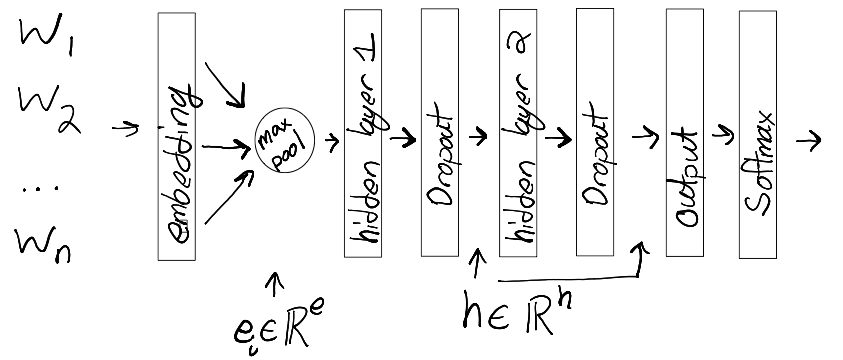